In [ ]:
!pip install tensorflow==2.3.0
!pip install tf-keras-vis tensorflow

In [ ]:
!pip install quickdraw

In [ ]:
# get owl data

from quickdraw import QuickDrawData
from quickdraw import QuickDrawDataGroup

num_owls_train = 500
num_owls_test = 200
num_owls_valid = 50

num_fish_train = 500
num_fish_test = 200
num_fish_valid = 50

owls = QuickDrawDataGroup("owl")
for i in range(num_owls_train):
    owls.get_drawing().image.save("./data/images/train/owl/owl" + str(i) + ".png")
for i in range(num_owls_test):
    owls.get_drawing().image.save("./data/images/test/owl/owl" + str(i) + ".png")
for i in range(num_owls_valid):
    owls.get_drawing().image.save("./data/images/valid/owl/owl" + str(i) + ".png")

fish = QuickDrawDataGroup("fish")
for i in range(num_fish_train):
    fish.get_drawing().image.save("./data/images/train/fish/fish" + str(i) + ".png")
for i in range(num_fish_test):
    fish.get_drawing().image.save("./data/images/test/fish/fish" + str(i) + ".png")
for i in range(num_fish_valid):
    fish.get_drawing().image.save("./data/images/valid/fish/fish" + str(i) + ".png")

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

C:\Users\rodam\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\rodam\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Tensorflow recognized 0 GPUs


In [1]:
# Parsing in imagenet class data

imagelabels = open("./data/imagenetlabels.txt", "r")
netlabels1 = imagelabels.readlines()
netlabels = dict()
count = 0
for line in netlabels1:
    if "{" in line:
        line = line.replace("{", "")
    elif "}" in line:
        line = line.replace("}", "")
    if "'" in line:
        line = line.replace("'", "")
    line = line.strip()
    if count != 999:
        line = line[:-1]
    result = ''.join([i for i in line if not i.isdigit()])[2:]
    netlabels[count] = result
    count += 1

netlabels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [5]:
# Importing pretrained vgg16 with imagenet weights

from tensorflow.keras.applications.vgg16 import VGG16 as Model

base_model = Model(weights='imagenet', input_shape = (224, 224, 3), include_top = False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory("./data/images/train",
                                             shuffle=True,
                                             batch_size=50,
                                             image_size=(224, 224))

Found 1000 files belonging to 2 classes.


In [13]:
validation_dataset = image_dataset_from_directory("./data/images/valid",
                                                  shuffle=True,
                                                  batch_size=10,
                                                  image_size=(224, 224))

Found 100 files belonging to 2 classes.


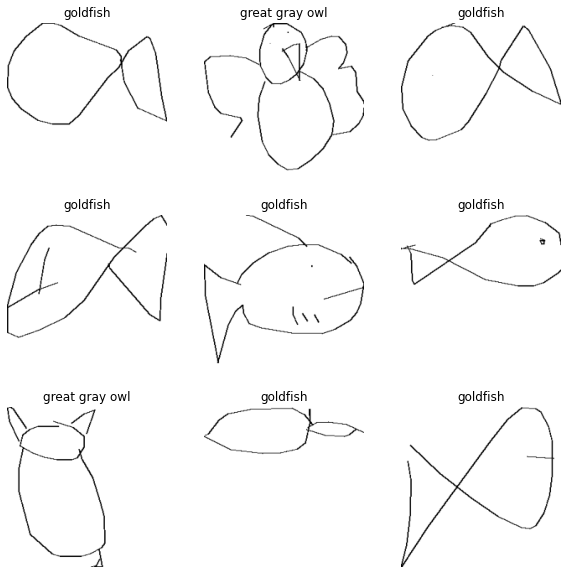

In [15]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
test_dataset = image_dataset_from_directory("./data/images/test/pictures", shuffle=True, batch_size=10, image_size=(224, 224))

Found 40 files belonging to 2 classes.


In [21]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

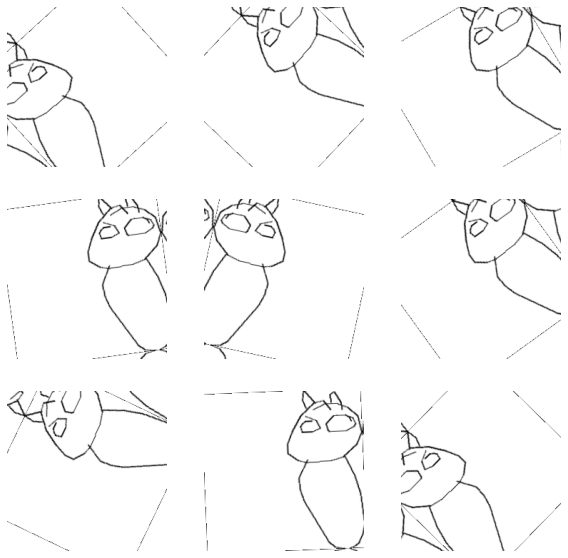

In [22]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(50, 7, 7, 512)


In [27]:
base_model.trainable = False

In [28]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [32]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [35]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 [==============================] - 5s 533ms/step - loss: 0.0000e+00 - accuracy: 0.5000


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


ValueError: in user code:

    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.trainable_variables)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2737 _minimize
        trainable_variables))
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    C:\Users\rodam\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense_3/kernel:0', 'dense_3/bias:0'].


In [6]:
import os
from tensorflow.keras.preprocessing.image import load_img

labels = ["owl", "fish"]

x_train = []
y_train = []
for root, dirs, files in os.walk("./data/images", topdown=False):
    if "drawings" in root:
        temp = 0
        for chr in files[0]:
            if chr.isdigit():
                temp = files[0].index(chr)
        label = files[0][0 : temp]
        print(files[0])
        for name in files:
            class_num = labels.index(label)
            x_train.append(np.array(load_img(os.path.join(root, name), target_size=(224, 224))))
            y_train.append(np.array(class_num))

In [7]:
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load images and convert to numpy array
images = []
cols = 5
rows = 8

for root, dirs, files in os.walk("./data/images/test/pictures", topdown=False):
    for name in files:
        images.append(load_img(os.path.join(root, name), target_size=(224, 224)))

nparrays = []
for img in images:
    nparrays.append(np.array(img))

images = np.asarray(nparrays)

# Prep for input into VGG16
X = preprocess_input(images)

In [8]:
# Model predictions and accuracy

from tensorflow.keras.applications.vgg16 import decode_predictions
predictions = model.predict(images)
labels = decode_predictions(predictions)

# 2d array of the top five predictions for each image
all_labels = []
all_accuracies = []

# array of the top prediction for each image
true_labels = []
true_accuracies = []

for i in range(len(labels)):
    
    # top prediction information
    name = labels[i][0][1]
    if "_" in name:
        name = name.replace("_", " ")
    true_labels.append(name)
    true_accuracies.append(round(float(labels[i][0][2])*100.0, 2))
    
    # all prediction information
    names = []
    accuracies = []
    for j in range(len(labels[i])):
        name = labels[i][j][1]
        if "_" in name:
            name = name.replace("_", " ")
        names.append(name)
        accuracies.append(round(float(labels[i][j][2])*100.0, 2))
    all_labels.append(names)
    all_accuracies.append(accuracies)


classes = []
for label in true_labels:
    for key, value in netlabels.items():
        if label in value:
            classes.append(int(key))
            break

print(classes)

[584, 51, 110, 767, 600, 549, 723, 916, 723, 534, 765, 711, 719, 1, 719, 389, 1, 397, 1, 818, 24, 21, 545, 562, 24, 87, 892, 24, 24, 24, 24, 99, 584, 24, 24, 24, 24, 24, 24, 24]


In [9]:
# information for each picture

for i in range(len(labels)):
    print("\033[1m" + "Information for picture {}".format(i+1) + "\033[0m")
    print("Top prediction: {}".format(true_labels[i]))
    print("Accuracy: {}%".format(str(true_accuracies[i])))
    print()
    print("All predictions: {}".format(str(all_labels[i])))
    print("All accuracies: {}".format(str(all_accuracies[i])))
    print()

Information for picture 1
Top prediction: hair slide
Accuracy: 59.2%

All predictions: ['hair slide', 'pinwheel', 'piggy bank', 'electric fan', 'ballpoint']
All accuracies: [59.2, 37.22, 1.48, 0.39, 0.22]

Information for picture 2
Top prediction: triceratops
Accuracy: 79.47%

All predictions: ['triceratops', 'puffer', 'armadillo', 'mask', 'hair slide']
All accuracies: [79.47, 11.62, 1.88, 1.3, 1.29]

Information for picture 3
Top prediction: flatworm
Accuracy: 56.36%

All predictions: ['flatworm', 'nipple', 'piggy bank', 'conch', 'whistle']
All accuracies: [56.36, 8.3, 7.18, 2.31, 2.24]

Information for picture 4
Top prediction: rubber eraser
Accuracy: 23.92%

All predictions: ['rubber eraser', 'hair slide', 'nipple', 'jigsaw puzzle', 'piggy bank']
All accuracies: [23.92, 22.46, 9.73, 7.75, 7.09]

Information for picture 5
Top prediction: hook
Accuracy: 10.97%

All predictions: ['hook', 'piggy bank', 'triceratops', 'candle', 'carousel']
All accuracies: [10.97, 8.9, 8.49, 6.53, 6.42]



In [ ]:
# Rendering
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(str(i+1) + ". " + title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Alternative replacement function
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# Imagenet indices
score = CategoricalScore(classes)

In [ ]:
# Vanilla Saliency

#%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(saliency_map[i], cmap='jet')
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()

In [ ]:
# SmoothGrad

#%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    ax[dim2][count].set_title(title, fontsize=14)
    ax[dim2][count].imshow(saliency_map[i], cmap='jet')
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.savefig('data/saliency maps/smoothgrad.png')
plt.show()

In [ ]:
# GradCam++

#%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.savefig('data/saliency maps/gradcam_plus_plus.png')
plt.show()

In [ ]:
# Faster-ScoreCAM

#%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 20))
count = 0
dim2 = 0
for i, title in enumerate(true_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[dim2][count].set_title(title, fontsize=16)
    ax[dim2][count].imshow(images[i])
    ax[dim2][count].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[dim2][count].axis('off')
    count += 1
    if count == cols:
        dim2 += 1
        count = 0
plt.tight_layout()
plt.show()